In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from skimage import color, io, morphology

# Dataset generator

In [2]:
def build_file_dict(folder):
    file_dict = {}
    for foldername, subfolders, filenames in os.walk(folder):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            file_dict[filename] = file_path
    return file_dict

In [3]:
working_directory =  r"/home/crest/z/hwang_Pro/data/2023_hokkaido_potato"
img_folder = os.path.join(working_directory, 'images')
img_dict = build_file_dict(img_folder)

# CV mask archive

In [4]:
def get_mask(img_path):
    img_np = plt.imread(img_path)

    h,w,d = img_np.shape

    # convert to LAB color space
    lab_image = color.rgb2lab(img_np)

    # get color channel
    a_channel = lab_image[:, :, 1]
    b_channel = lab_image[:, :, 2]

    # set channel threshold
    color_threshold = 20  # 颜色阈值

    # 创建掩膜
    mask = np.logical_or(a_channel > color_threshold, b_channel > color_threshold)

    # fill holes in the mask
    filled_mask = morphology.remove_small_holes(mask, area_threshold=h*w*0.005)
    cleaned_mask = morphology.remove_small_objects(filled_mask, min_size=h*w*0.005)


    # 将掩膜应用于原始图像
    result = np.copy(img_np)
    result[~cleaned_mask] = 0

    return cleaned_mask, img_np, result

# SAM directly

In [4]:
import torch

from segment_anything import sam_model_registry

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

sam = sam_model_registry['vit_b'](checkpoint=r'sam_models/sam_vit_b_01ec64.pth')
sam.to(device=DEVICE)

cuda:0


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [5]:
from segment_anything import SamAutomaticMaskGenerator

mask_generator = SamAutomaticMaskGenerator(sam)

In [6]:
img_list = list(img_dict.keys())
random_img = random.choice(img_list)

img_np = io.imread(img_dict[random_img])

result = mask_generator.generate(img_np)

OutOfMemoryError: CUDA out of memory. Tried to allocate 8.61 GiB (GPU 0; 23.66 GiB total capacity; 13.24 GiB already allocated; 8.27 GiB free; 13.97 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Use ultralytics.fastSAM

In [5]:
from ultralytics import FastSAM
from ultralytics.models.fastsam import FastSAMPrompt

In [6]:
# Create a FastSAM model
model = FastSAM('sam_models/FastSAM-s.pt') 

In [7]:
img_list = list(img_dict.keys())
random_img = random.choice(img_list)

img_path = img_dict[random_img]

img_np = io.imread(img_path)

In [8]:
everything_results = model(img_path, device='cuda:0', retina_masks=True, imgsz=2048, conf=0.4, iou=0.9)


image 1/1 /home/crest/z/hwang_Pro/data/2023_hokkaido_potato/images/R7-5/002/DSC_002_20230915_1154194687.jpg: 1376x2048 110 objects, 59.1ms
Speed: 13.1ms preprocess, 59.1ms inference, 83.5ms postprocess per image at shape (1, 3, 1376, 2048)


In [9]:
numpy_array = everything_results[0].masks.data.cpu().numpy()

In [10]:
numpy_array.shape

(110, 3456, 5184)

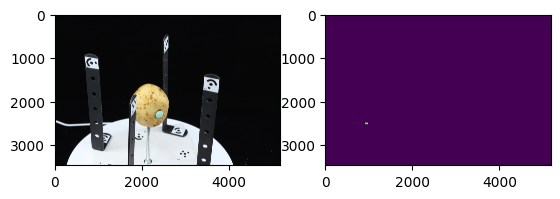

In [11]:
fig,ax = plt.subplots(1,2)

ax[0].imshow(img_np)
ax[1].imshow(numpy_array[76,:,:])

In [28]:
len(everything_results)

1

In [29]:
everything_results[0]

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: ultralytics.engine.results.Masks object
names: {0: 'object'}
orig_img: array([[[5, 6, 2],
        [4, 5, 1],
        [5, 6, 2],
        ...,
        [6, 7, 5],
        [6, 7, 5],
        [6, 7, 5]],

       [[5, 6, 2],
        [5, 6, 2],
        [5, 6, 2],
        ...,
        [6, 7, 5],
        [6, 7, 5],
        [5, 6, 4]],

       [[4, 5, 1],
        [4, 5, 1],
        [7, 6, 2],
        ...,
        [5, 6, 4],
        [5, 6, 4],
        [4, 5, 3]],

       ...,

       [[8, 8, 8],
        [8, 8, 8],
        [7, 7, 7],
        ...,
        [7, 7, 7],
        [6, 6, 6],
        [4, 4, 4]],

       [[7, 7, 7],
        [8, 8, 8],
        [7, 7, 7],
        ...,
        [7, 7, 7],
        [5, 5, 5],
        [5, 5, 5]],

       [[7, 7, 7],
        [7, 7, 7],
        [9, 7, 7],
        ...,
        [6, 6, 6],
        [5, 5, 5],
        [5, 5, 5]]], dtype=uint8)

In [12]:
mask, img_np, result = get_mask(img_dict[random_img])

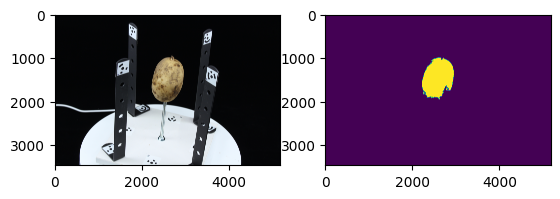

In [68]:
fig,ax = plt.subplots(1,2)

ax[0].imshow(img_np)
ax[1].imshow(mask)

In [21]:
segmentation = np.where(mask == True)

buffer = 150

x_min = int(np.min(segmentation[1])) - buffer
x_max = int(np.max(segmentation[1])) + buffer
y_min = int(np.min(segmentation[0])) - buffer
y_max = int(np.max(segmentation[0])) + buffer

bbox = x_min, x_max, y_min, y_max
bbox

(1592, 2768, 1445, 2744)

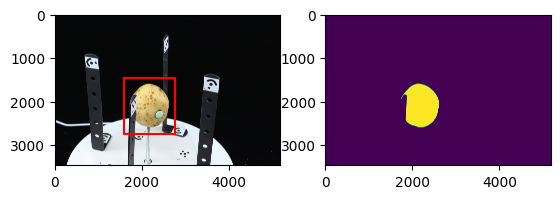

In [22]:
fig,ax = plt.subplots(1,2)

ax[0].imshow(img_np)
ax[1].imshow(mask)

ax[0].plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], color='r')

In [23]:
prompt_process = FastSAMPrompt(img_path, everything_results, device='cuda:0')

In [24]:
ann = prompt_process.box_prompt(bbox=[x_min, x_max, y_min, y_max])

In [25]:
ann[0]

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: ultralytics.engine.results.Masks object
names: {0: 'object'}
orig_img: array([[[ 8,  8,  8],
        [ 8,  8,  8],
        [10,  8,  8],
        ...,
        [ 8,  6,  5],
        [ 8,  6,  5],
        [ 9,  7,  6]],

       [[ 8,  8,  8],
        [ 8,  8,  8],
        [10,  8,  8],
        ...,
        [ 8,  6,  5],
        [ 8,  6,  5],
        [ 9,  7,  6]],

       [[ 9,  9,  9],
        [ 9,  9,  9],
        [10,  8,  8],
        ...,
        [ 9,  7,  6],
        [ 9,  7,  6],
        [ 9,  7,  6]],

       ...,

       [[10,  8,  7],
        [10,  8,  7],
        [10,  8,  7],
        ...,
        [11,  9,  9],
        [11,  9,  9],
        [12, 10, 10]],

       [[11,  9,  9],
        [10,  8,  8],
        [10,  8,  8],
        ...,
        [10,  8,  8],
        [11,  9,  8],
        [12, 10,  9]],

       [[ 8,  8,  8],
        [ 8,  8,  8],
       

In [26]:
sam_mask = ann[0].masks.masks.numpy().astype(bool)
sam_mask.shape

WARNING ⚠️ 'Masks.masks' is deprecated. Use 'Masks.data' instead.


(1, 3456, 5184)

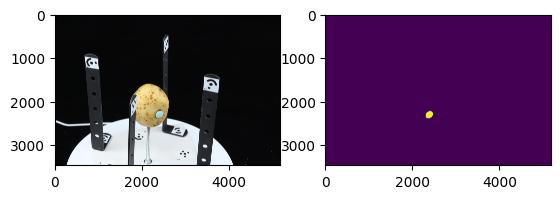

In [27]:
fig,ax = plt.subplots(1,2)

ax[0].imshow(img_np)
ax[1].imshow(sam_mask[0,:,:])

## save to local file and check

In [90]:
mask_color = np.copy(img_np)
mask_color[~sam_mask[0,:,:]] = 0

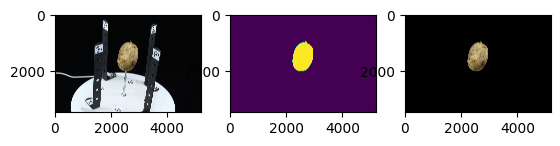

In [91]:
fig,ax = plt.subplots(1,3)

ax[0].imshow(img_np)
ax[1].imshow(sam_mask[0,:,:])
ax[2].imshow(mask_color)

In [96]:
io.imsave(f'__pycache__/4_{random_img}_mask.png', sam_mask)
io.imsave(f'__pycache__/4_{random_img}_view.png', mask_color)

/tmp/ipykernel_4640/1563323836.py:1: UserWarning: __pycache__/4_DSC_002_0042.jpg_mask.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(f'__pycache__/4_{random_img}_mask.png', sam_mask)
